In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from import_data import get_data, read_processed_files, get_solar_actual, get_solar_estimate
from environment import market_env
from actor_critic import ActorCriticAgent
from utils import plot_learning_curve
import numpy as np
import pandas as pd
import os

# Get Data

In [3]:
get_data()

retrieved demand
retrieved solar, wind
retrieved gen
retrieved price
retrieved solar capacity actual
retrieved solar capacity forecast
saved data


In [23]:
df_demand, df_demand_scaled, df_vre, df_vre_scaled, df_gen, df_gen_scaled, df_solar_cap_forecast, df_solar_cap_actual, df_mcp = read_processed_files()

In [24]:
# Example usage
env = market_env(demand=df_demand_scaled, re=df_vre_scaled, capacity_forecast= df_solar_cap_forecast, capacity_actual=df_solar_cap_actual, prices=df_mcp, eps_length=24, capacity=200, mc=30)

/Users/louis.skowronek/miniforge3/envs/bda_env/lib/python3.9/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [25]:
input_size = env.observation_space.shape[0]
n_actions_prc = env.action_space[0].n
n_actions_vol = env.action_space[1].n
n_games = 1000

agent = ActorCriticAgent(input_size, n_actions_prc, n_actions_vol)

best_score = env.reward_range[0]
score_history = []
load_checkpoint = False

In [26]:
observation = env.reset()

In [27]:
import torch

In [32]:
torch.cat([torch.tensor([2]), torch.tensor([3])])[0]

tensor(2)

In [36]:
torch.cat([agent.choose_action(observation)])

TypeError: expected Tensor as element 0 in argument 0, but got tuple

In [40]:
agent.choose_action(observation)[0], agent.choose_action(observation)[1]

tensor(19)

In [9]:
reward_history = []

if load_checkpoint:
    agent.load_models()

for i in range(n_games):
    observation = env.reset()
    done = False
    score = 0


    while not done:

        action = agent.choose_action(observation)

        observation_next, reward, done, _ = env.step(action)
        score += reward
        if not load_checkpoint:
            agent.update(observation, reward, observation_next, done)
        observation = observation_next

    score_history.append(score)
    avg_score = np.mean(score_history[-100:])

    if avg_score > best_score:
        best_score = avg_score
        if not load_checkpoint:
            agent.save_models()

    print('episode ', i, 'score %.1f' % score, 'avg_score %.1f' % avg_score)

ValueError: The value argument to log_prob must be a Tensor

In [19]:
env.results_ep.describe()

,reward,market price,bid price,bid volume
count,18336.000000,18336.000000,18336.000000,18336.0
mean,7.130496,97.223395,33.787304,200.0
std,3.793304,108.177987,27.562829,0.0
min,-6.333300,-90.010000,0.000000,200.0
25%,6.709900,35.150000,30.000000,200.0
50%,8.402900,53.070000,30.000000,200.0
75%,9.760950,117.992500,30.000000,200.0
max,12.007600,850.000000,294.000000,200.0


In [20]:
env.results_ep

,reward,market price,bid price,bid volume
2021-09-12 00:00:00+02:00,0.0000,105.05,294.0,200.0
2021-09-12 01:00:00+02:00,0.0000,99.17,156.0,200.0
2021-09-12 02:00:00+02:00,0.0000,99.02,282.0,200.0
2021-09-12 03:00:00+02:00,0.0000,95.38,246.0,200.0
2021-09-12 04:00:00+02:00,0.0000,97.57,132.0,200.0
...,...,...,...,...
2019-03-29 19:00:00+01:00,8.2602,49.33,30.0,200.0
2019-03-29 20:00:00+01:00,8.1856,47.94,30.0,200.0
2019-03-29 21:00:00+01:00,7.8667,43.04,30.0,200.0
2019-03-29 22:00:00+01:00,7.8442,42.75,30.0,200.0


<Axes: >

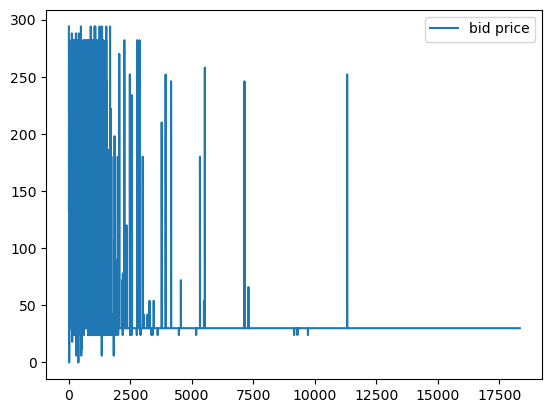

In [21]:
env.results_ep.reset_index().plot(y=['bid price'])

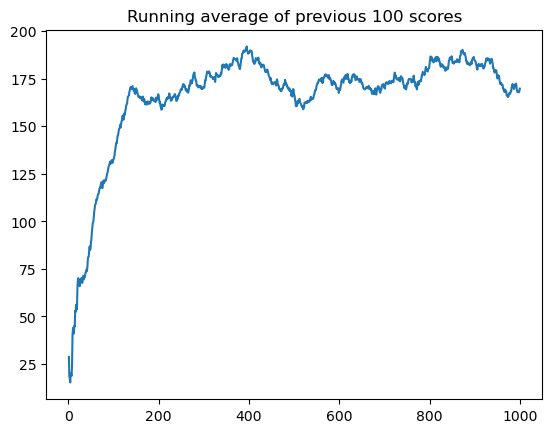

In [22]:
x = [i + 1 for i in range(len(score_history))]
plot_learning_curve(x, score_history)

In [3]:
import gym
from gym.spaces import Box, Discrete

# New Tests

In [3]:
from entsoe import EntsoePandasClient
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from import_data import aggregate_hourly, drop_incomplete_datapoints

In [4]:
# your_key = '9ab2e188-d454-44be-bce7-ea9dc8863723'
your_key = '3a72c137-c318-4dd5-ac00-2d3be87966a8'

country_code = 'DE_LU'  # Germany-Luxembourg

client = EntsoePandasClient(api_key=your_key)

In [7]:
start = pd.Timestamp(year=2022, month=1, day=1, tz="europe/brussels")
end = pd.Timestamp.now(tz="europe/brussels").floor('D') + pd.Timedelta(days=2)

In [190]:
# make api call
solar_actual = pd.DataFrame(client.query_generation(country_code, start=start, end=end, psr_type=None))

In [197]:
solar_actual

2022-01-01 00:00:00+01:00        0.0
2022-01-01 01:00:00+01:00        0.0
2022-01-01 02:00:00+01:00        0.0
2022-01-01 03:00:00+01:00        0.0
2022-01-01 04:00:00+01:00        0.0
                              ...   
2023-06-07 19:00:00+02:00    20665.0
2023-06-07 20:00:00+02:00     6540.0
2023-06-07 21:00:00+02:00      417.0
2023-06-07 22:00:00+02:00        1.0
2023-06-07 23:00:00+02:00        0.0
Name: Actual Aggregated, Length: 12480, dtype: float64

In [5]:
from import_data import get_solar_estimate